In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [3]:
# 오토인코더 : 어떤 지도 없이도 잠재표현 또는 코딩이라 부르는 입력 데이터의 밀집 표현을 학습할 수 있는 인공 신경망
# GAN : 생성적 적대 신경망

# 오토인코더는 항상 두부분으로 구성. 입력을 내부표현으로 바꾸는 인코더(인지 네트워크)와 내부표현을 출력으로 바꾸는 디코더(생성 네크워크)
# 일반적으로 오토인코더는 다층 퍼셉트론과 구조 동일
# 내부의 표현이 입력 데이터보다 저차원이기 때문에 과소완전이라고 함

## 과소완전 선형 오토인코더로 PCA 수행

In [10]:
# 오토인코터가 선형 활성화 함수만 사용하고 비용 함수가 평균 제곱 오차라면 결국 주성분 분석을 수행하는 것으로 볼 수 있음

# 3D 데이터셋에 PCA를 적용해 2D에 투영하는 간단한 선형 오토인코더
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

In [12]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 840us/step - loss: 0.2726
Epoch 2/20
2/2 [==============================] - 0s 597us/step - loss: 0.1026
Epoch 3/20
2/2 [==============================] - 0s 651us/step - loss: 0.0547
Epoch 4/20
2/2 [==============================] - 0s 582us/step - loss: 0.0512
Epoch 5/20
2/2 [==============================] - 0s 690us/step - loss: 0.0773
Epoch 6/20
2/2 [==============================] - 0s 1ms/step - loss: 0.2136
Epoch 7/20
2/2 [==============================] - 0s 731us/step - loss: 0.1043
Epoch 8/20
2/2 [==============================] - 0s 640us/step - loss: 0.0315
Epoch 9/20
2/2 [==============================] - 0s 689us/step - loss: 0.0241
Epoch 10/20
2/2 [==============================] - 0s 675us/step - loss: 0.0195
Epoch 11/20
2/2 [==============================] - 0s 718us/step - loss: 0.0142
Epoch 12/20
2/2 [==============================] - 0s 681us/step - loss: 0.0106
Epoch 13/20
2/2 [==============================] - 

In [13]:
codings = encoder.predict(X_train)

그림 저장 linear_autoencoder_pca_plot


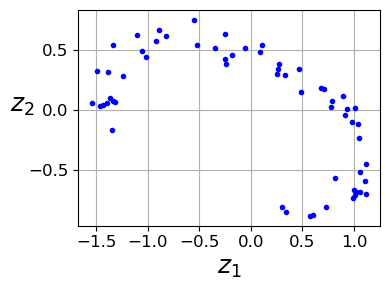

In [14]:
fig = plt.figure(figsize=(4, 3))
plt.plot(codings[:, 0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

## 적층 오토인코더

In [19]:
# 적층 오코인코더 (심층 오토인코더): 은닉층 여러개
# 전형적으로 가운데 은닉층 기준으로 대칭

# 케라스를 사용하여 적층 오토인코더 구현
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [20]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [21]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3815 - rounded_accuracy: 0.8487 - val_loss: 0.3164 - val_rounded_accuracy: 0.9007
Epoch 2/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3082 - rounded_accuracy: 0.9127 - val_loss: 0.3021 - val_rounded_accuracy: 0.9198
Epoch 3/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2997 - rounded_accuracy: 0.9204 - val_loss: 0.2984 - val_rounded_accuracy: 0.9202
Epoch 4/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2959 - rounded_accuracy: 0.9240 - val_loss: 0.2938 - val_rounded_accuracy: 0.9286
Epoch 5/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2928 - rounded_accuracy: 0.9268 - val_loss: 0.2919 - val_rounded_accuracy: 0.9285
Epoch 6/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2920 - rounded_accuracy: 0.9283 - val_loss: 0.2914 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==================

그림 저장 reconstruction_plot


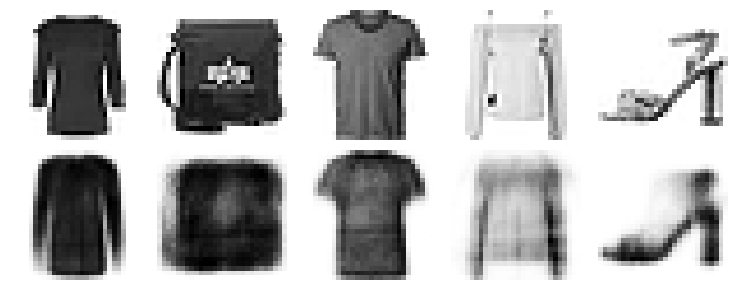

In [23]:
# 재구성 시각화
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

In [ ]:
# 패션 MNIST 데이터셋 시각화
